### Review: Monte Carlo Constant-alpha Control
> short for: MC Control

Remember that the constant-$\alpha$ MC control algorithm alternates between **policy evaluation** and **policy improvement** steps to recover the optimal policy $\pi_*$ .
$$
\begin{align}
\pi_* = argmax_{\pi}(Q(S_t, A_t)) \\
Q(S_t, A_t) = \mathbb{E}_\pi[G_t \mid S=S_t, A=A_t] = \frac{1}{N}\sum_{0}^{N} G_t \\
\end{align}
$$
In the **policy evaluation** step, the **agent collects an episode** $S_0, A_0, R_0, S_1, \cdots, S_T$ using the most recent policy $\pi$, After the episode finishes, for each time-step $t$, if the corresponding  state-action pair $(S_t, A_t)$ is a first visit, the Q-table is modified using the following **update equation**:
$$
\begin{align}
Q(S_t, A_t) = Q(S_t, A_t) + \alpha (G_t - Q(S_t, A_t)) \\
G_t := \sum_{i=0}^{T}\gamma^i R_{t+i} \\
\end{align}
$$
$G_t$ is the return at timestep $t$, and $Q(S_t, A_t)$ is the entry in the Q-table corresponding to state $S_t$ and action $A_t$

The main idea behind this **update equation** is that $Q(S_t, A_t)$ contains the agent's estimate for the expected return if the environment is in state $S_t$ and the agent selects action $A_t$. Then we push the value of  $Q(S_t, A_t)$ to make it agree slightly more with the return. The magnitude of the change that we make to $Q(S_t, A_t)$ is controlled by the hyperparameter $0<α≤1$.


### TD Control: SARSA

#### Idea

The main darwbacks is that the **agent collects an episode** in the **policy evaluation** step. What if we could update the Q-Table in real-time, without waiting for the entire episode to finish? This approach uses a small time window of information to make updates. By leveraging the current Q-value estimate and **the estimated value of the next state-action pair(lookup the existed Q table to find certain pair), we compute an $G_t$'s alternative estimate**. The Q-value is then adjusted incrementally toward this estimate. This method forms the basis of temporal difference control, which will be explored in greater detail later.

![](./images/td-learning-sarsa.png)

In the algorithm, the number of episodes the agent collects is equal to `num_episodes`. 

For each episode, the agent repeat:
1. Takes the action $A_t$ (from the current state $S_t$) that is $ϵ$-greedy with respect to the Q-table.
2. Receives the reward $R_{t}$ and the next state $S_{t+1}$.
3. Chooses the next action $A_{t+1}$ (from the next state $S_{t+1}$) that is $ϵ$-greedy with respect to the Q-table.
4. Uses the information in the tuple ($S_t$, $A_t$, $R_{t}$, $S_{t+1}$, $A_{t+1}$) to update the entry $Q(S_t, A_t)$ in the Q-table corresponding to the current state $S_t$ and the action $A_t$.

#### Psedocode

> note: we refer $R_{t}$ as $R_{t+1}$ current reward based $S_t$ and $A_t$, just for name convention, so slightly different with below's define.

![](./images/td-learning-sarsa-psedocode.png)




In [3]:
import sys
import gymnasium as gym
import numpy as np
from collections import defaultdict

In [33]:
def epsilon_greedy(actions, epsilon):
    nA = len(actions)
    probs = np.ones(nA) * (epsilon / nA)
    best_action = np.argmax(actions)
    probs[best_action] = 1 - epsilon + (epsilon / nA)
    return probs


def td_control_sarsa(env, num_episodes, alpha, gamma=1.0, eps_decay=0.999, eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = 1.0
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        epsilon = max(epsilon*eps_decay, eps_min)
        
        state, info = env.reset()
        while True:
            # S_t   --> A_t
            probs = epsilon_greedy(Q[state], epsilon)
            action = np.random.choice(np.arange(nA), p=probs)

            # A_t   --> R_t, S_t+1, 
            next_state, reward, done, truncated, info = env.step(action)
            
            # S_t+1 --> A_t+1 using same policy
            next_action = np.random.choice(np.arange(nA), p=probs)

            # update Q table
            G_estimate = reward + gamma * Q[next_state][next_action]
            Q[state][action] = Q[state][action] + alpha * (G_estimate - Q[state][action])

            state = next_state
            if done:
                break
    
    policy = {k: np.argmax(v) for k, v in Q.items()}
    return policy, Q

In [34]:
env = gym.make('Blackjack-v1')

In [35]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [36]:
# obtain the estimated optimal policy and action-value function
policy, Q = td_control_sarsa(env, 500000, alpha=0.02, eps_min=0.05)

Episode 500000/500000.

In [37]:
from plot_utils import plot_blackjack_values, plot_policy

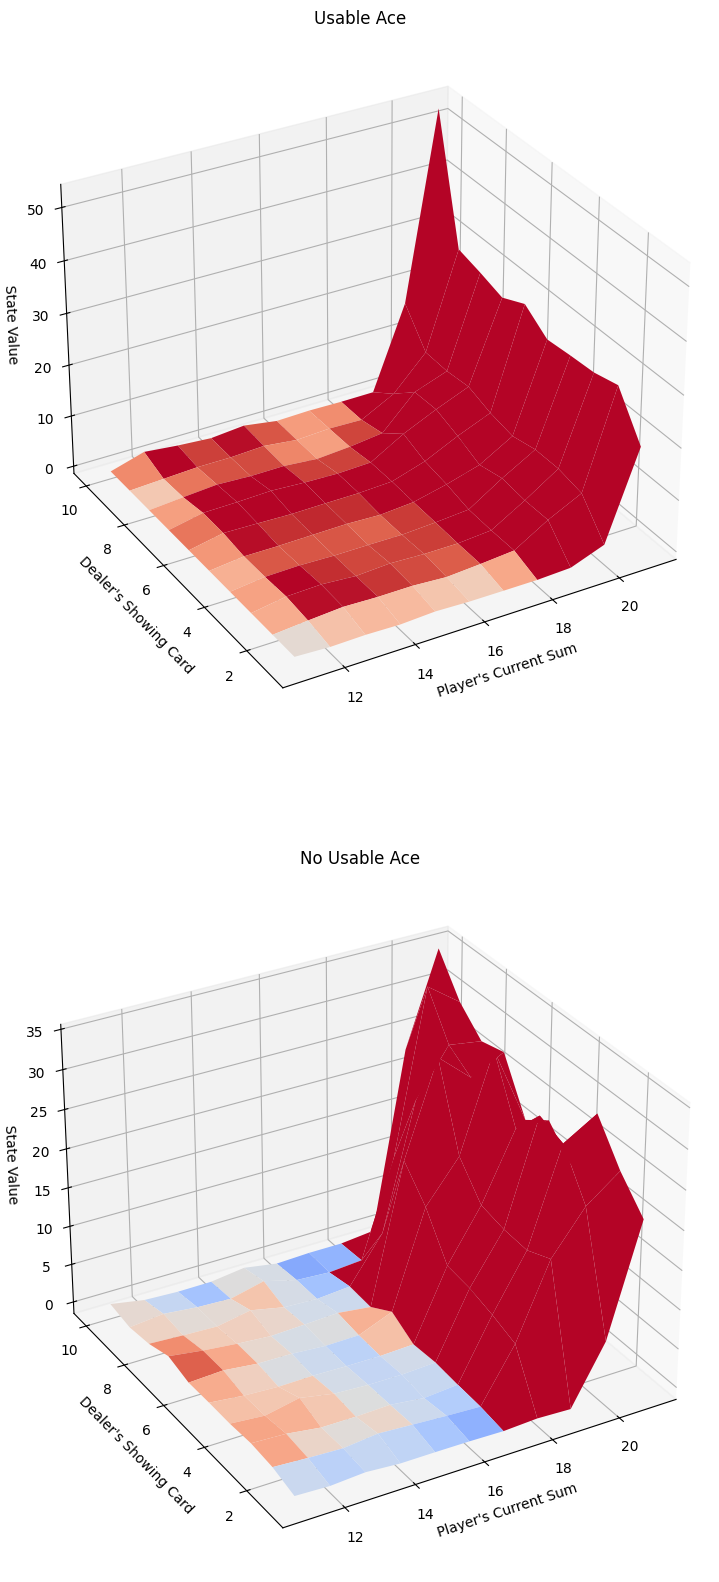

In [38]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

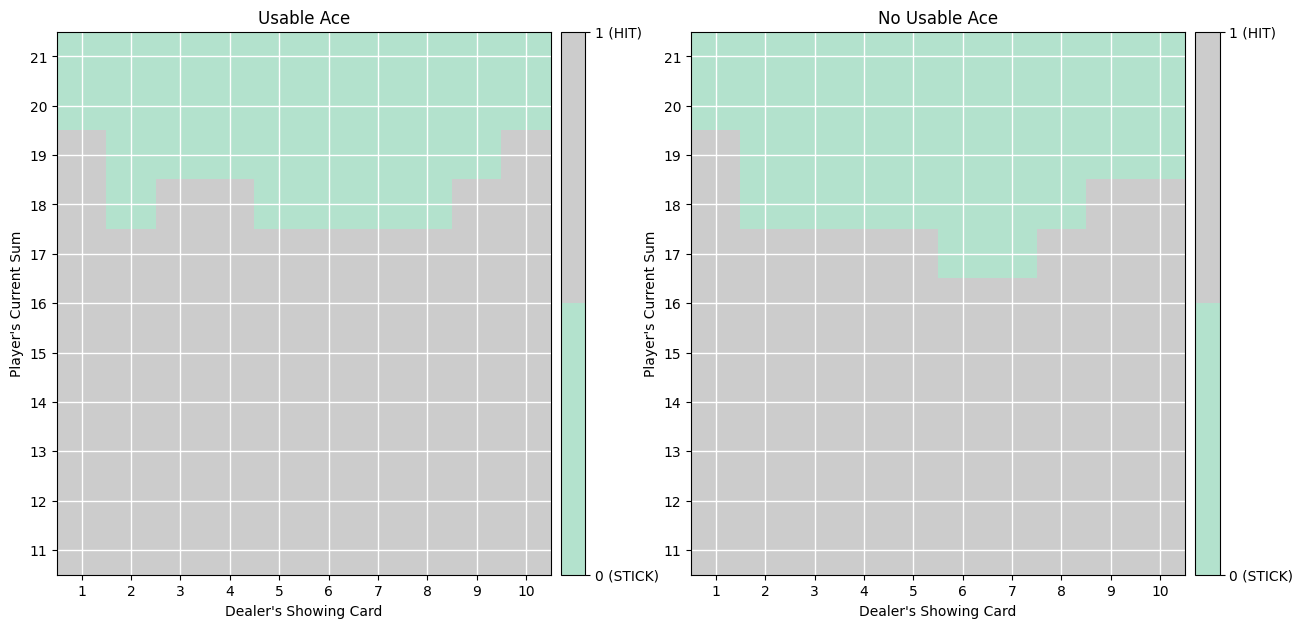

In [39]:
# plot the policy
plot_policy(policy)

### TD Control: SARSA-Max (Q-Learning)

#### Idea

Instead of using the action ($A_{t+1}$) selected by the ε-greedy policy for the update, SARSA-Max uses the **greedy action** (the action that maximizes the Q-value in the next state).

The update formula incorporates the greedy action, which directly approximates the optimal value function:
$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t) \right]
$$


**Key Differences**:
  - In SARSA, the updates are based on the actions actually experienced by the agent (on-policy).
  - In SARSA-Max, the updates use the greedy action (off-policy), regardless of the action selected by the ε-greedy policy.
  - SARSA pushes the action values closer to evaluating the **ε-greedy policy** being followed by the agent.
  - SARSA-Max directly approximates the **optimal value function** at every time step.

![](./images/sarsamax-or-q-learning.png)


#### Psedocode

> note: we refer $R_{t}$ as $R_{t+1}$ current reward based $S_t$ and $A_t$, just for name convention, so slightly different with below's define.

![](./images/sarsamax-or-q-learning-psedocode.png)

In [40]:
def td_control_sarsamax(env, num_episodes, alpha, gamma=1.0, eps_decay=0.999, eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = 1.0
    
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        epsilon = max(epsilon*eps_decay, eps_min)
        
        state, info = env.reset()
        while True:
            # S_t   --> A_t
            probs = epsilon_greedy(Q[state], epsilon)
            action = np.random.choice(np.arange(nA), p=probs)

            # A_t   --> R_t, S_t+1, 
            next_state, reward, done, truncated, info = env.step(action)
            
            # S_t+1 --> A_t+1 using same policy
            next_action = np.argmax(Q[next_state])

            # update Q table
            G_estimate = reward + gamma * Q[next_state][next_action]
            Q[state][action] = Q[state][action] + alpha * (G_estimate - Q[state][action])

            state = next_state
            if done:
                break
    
    policy = {k: np.argmax(v) for k, v in Q.items()}
    return policy, Q

In [41]:
# obtain the estimated optimal policy and action-value function
policy, Q = td_control_sarsamax(env, 500000, alpha=0.02, eps_min=0.05)

Episode 500000/500000.

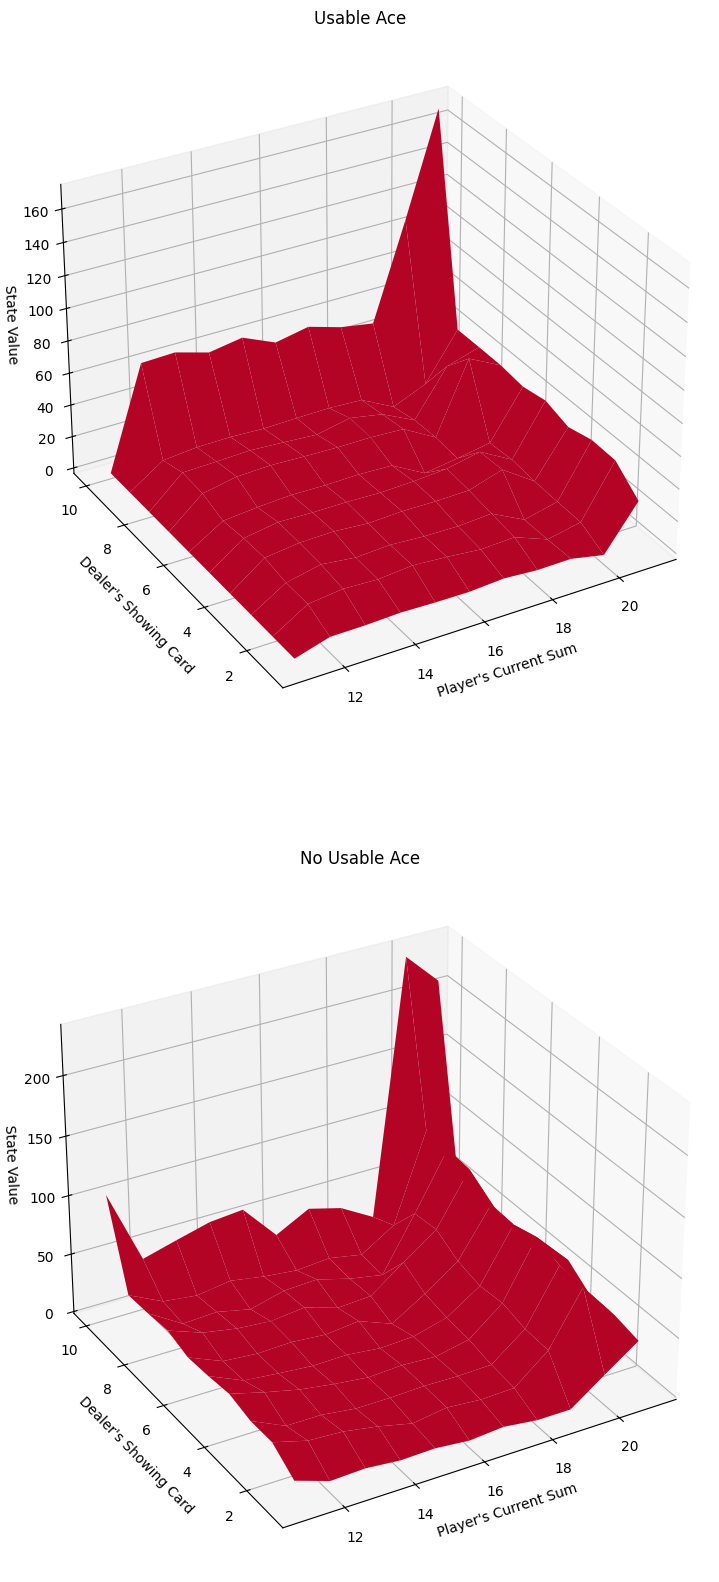

In [42]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

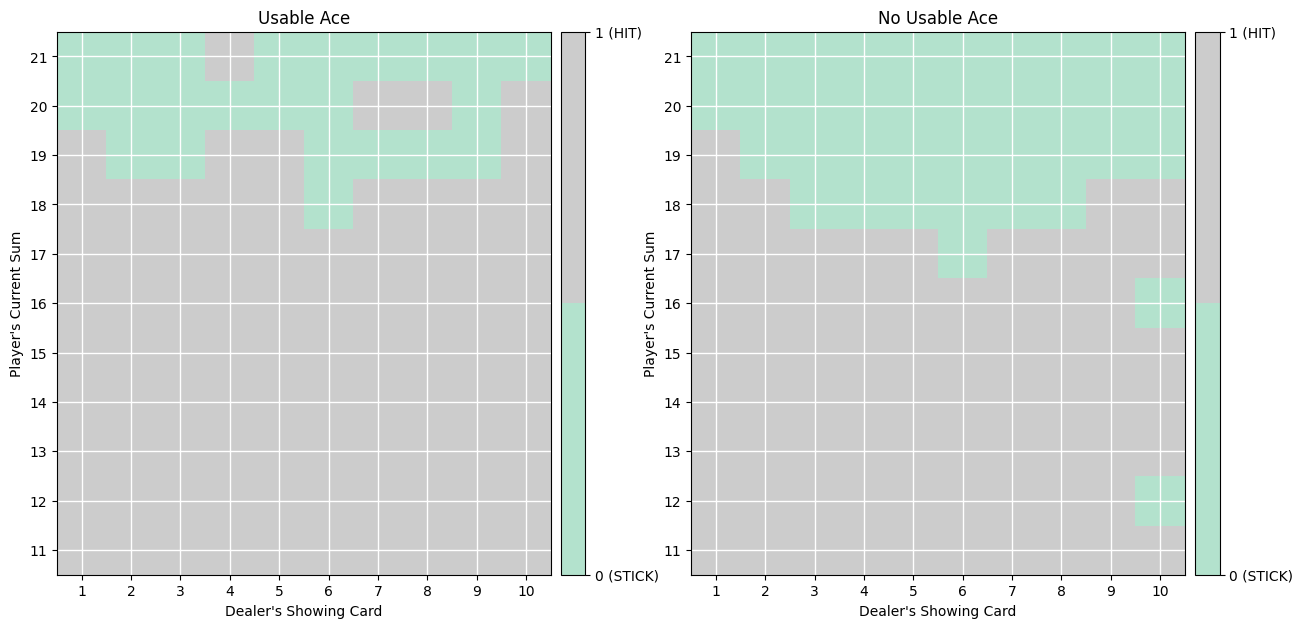

In [43]:
# plot the policy
plot_policy(policy)